In [11]:
# 必要なライブラリをインストール
#! pip install jijmodeling ommx ommx_pyscipopt_adapter ommx_python_mip_adapter deap matplotlib

# 使用する数理モデルの定式化

In [12]:
import jijmodeling as jm
from ommx_pyscipopt_adapter import instance_to_model, model_to_solution
from ommx.v1 import Instance, Solution
import time
import numpy as np


class Solver:
    def __init__(self):
        # Problem parameters
        p = jm.Placeholder("p", ndim=1, description="Profit values for each item")
        w = jm.Placeholder(
            "w",
            ndim=2,
            description="Weight matrix where w[m,i] is weight of item i in constraint m",
        )
        c = jm.Placeholder(
            "c", ndim=1, description="Capacity constraints for each dimension"
        )

        # Get dimensions from placeholders with latex representation
        N = p.len_at(0, latex="N")  # Number of items from length of profit array
        M = w.len_at(
            0, latex="M"
        )  # Number of constraints from first dimension of weight matrix

        # Indices
        i = jm.Element("i", (0, N), description="Item index")
        m = jm.Element("m", (0, M), description="Constraint index")

        # Decision variables
        x = jm.BinaryVar(
            "x", shape=(N,), description="Binary decision variable for item selection"
        )

        # Problem definition
        problem = jm.Problem("MultiConstrainedKnapsack", sense=jm.ProblemSense.MAXIMIZE)

        # Objective: Maximize total profit
        problem += jm.sum(i, p[i] * x[i])

        # Constraints: Weight constraints for each dimension
        problem += jm.Constraint(
            "capacity_constraints", jm.sum(i, w[m, i] * x[i]) <= c[m], forall=m
        )
        self.problem = problem

    def solve(self, p, w, c):
        # Create instance data
        instance_data = {"p": p, "w": w, "c": c}

        # Create interpreter and evaluate problem
        interpreter = jm.Interpreter(instance_data)
        instance: Instance = interpreter.eval_problem(self.problem)
        # PySCIPOpt model に変換
        model = instance_to_model(instance)
        # PySCIPOptのオプションを指定
        model.hideOutput(True)
        model.setParam("limits/time", 60)
        # 求解
        start = time.time()
        model.optimize()
        elapsed_time = time.time() - start
        # 解を取得し、`ommx.v1.Solution`に変換
        solution: Solution = model_to_solution(model, instance)
        # 経過時間と目的関数値を返す
        return elapsed_time, solution.objective

In [13]:
solver = Solver()
solver.problem

# ランダムなインスタンス生成

Generating Samples...  1
Generating Samples...  2
Generating Samples...  3
Generating Samples...  4
Generating Samples...  5
Generating Samples...  6
Generating Samples...  7
Generating Samples...  8
Generating Samples...  9
Generating Samples...  10


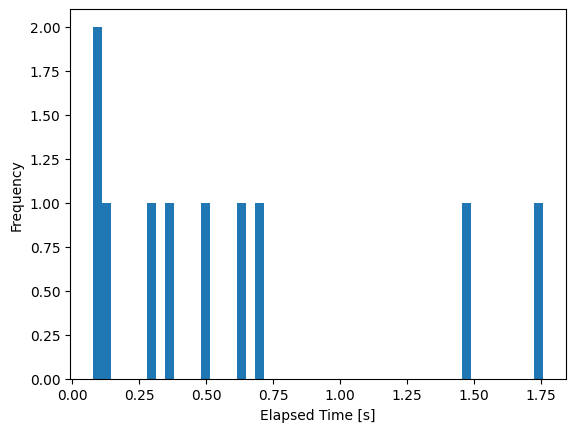

In [14]:
import numpy as np

N = 100
M = 10
p_lower = 1
p_upper = 999
w_lower = 1
w_upper = 999
c_lower = 10000
c_upper = 20000

s = Solver()
elapsed_times = []

for i in range(10): #(サンプルコードのため、100 -> 10 に変更)
    print(f"Generating Samples... ", i+1)
    instance_data = {
        "p": np.random.randint(p_lower, p_upper, size=(N), dtype=np.int32).tolist(),
        "w": np.random.randint(w_lower, w_upper, size=(M, N), dtype=np.int32).tolist(),
        "c": np.random.randint(c_lower, c_upper, size=(M), dtype=np.int32).tolist(),
    }

    elapsed_time, _ = s.solve(
        instance_data["p"], instance_data["w"], instance_data["c"]
    )
    elapsed_times.append(elapsed_time)

# Draw Histogram
import matplotlib.pyplot as plt

plt.hist(elapsed_times, bins=50)
plt.xlabel("Elapsed Time [s]")
plt.ylabel("Frequency")
plt.show()

# 遺伝的アルゴリズムの実装

In [15]:
from deap import base, creator, tools, algorithms
import random

# 行列のサイズ
N = 100
M = 10
matrix_sizes = {
    "p": (N, 1),  # Nx1 行列
    "w": (M, N),  # MxN 行列
    "c": (M, 1),  # Mx1 行列
}

# 個体の1次元ベクトル化のための長さ
p_size = np.prod(matrix_sizes["p"])
w_size = np.prod(matrix_sizes["w"])
c_size = np.prod(matrix_sizes["c"])

total_length = p_size + w_size + c_size


# 評価関数
def evaluate(individual):
    # 1次元ベクトルを行列に復元
    p_size = np.prod(matrix_sizes["p"])
    w_size = np.prod(matrix_sizes["w"])
    c_size = np.prod(matrix_sizes["c"])

    p = np.array(individual[:p_size]).reshape(matrix_sizes["p"]).reshape(N).tolist()
    w = (
        np.array(individual[p_size : p_size + w_size])
        .reshape(matrix_sizes["w"])
        .tolist()
    )
    c = (
        np.array(individual[p_size + w_size :])
        .reshape(matrix_sizes["c"])
        .reshape(M)
        .tolist()
    )

    # 問題を解く
    elapsed_time, _ = s.solve(p, w, c)

    return (elapsed_time,)


# DEAPのセットアップ
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # 難解度を最大化
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()


# 個体の生成
# 個体生成時の属性をカスタマイズ
def custom_individual():
    # p と w を範囲 [1, 999] で生成
    p_values = [random.uniform(1, 999) for _ in range(p_size)]
    w_values = [random.uniform(1, 999) for _ in range(w_size)]
    # c を範囲 [20000, 40000] で生成
    c_values = [random.uniform(10000, 20000) for _ in range(c_size)]
    return p_values + w_values + c_values


toolbox.register("individual", tools.initIterate, creator.Individual, custom_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 遺伝的操作
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)  # 2点交叉
toolbox.register(
    "mutate", tools.mutGaussian, mu=0, sigma=50, indpb=20
)  # ガウス分布による突然変異
toolbox.register("select", tools.selTournament, tournsize=3)  # トーナメント選択


random.seed(42)

# 初期集団の生成
pop = toolbox.population(n=30)  # 集団サイズ (サンプルコードのため、100 -> 30 に変更)

# 統計データの収集
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# 最適化の実行 (サンプルコードのため、世代数を40 -> 4 に変更)
pop, log = algorithms.eaSimple(
    pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=4, stats=stats, verbose=True
)

# 最適解の取得
best_ind = tools.selBest(pop, k=1)[0]
print("Best Individual (flattened):", best_ind)

# 最適解を行列に復元
p_size = np.prod(matrix_sizes["p"])
w_size = np.prod(matrix_sizes["w"])
c_size = np.prod(matrix_sizes["c"])

best_p = np.array(best_ind[:p_size]).reshape(matrix_sizes["p"])
best_w = np.array(best_ind[p_size : p_size + w_size]).reshape(matrix_sizes["w"])
best_c = np.array(best_ind[p_size + w_size :]).reshape(matrix_sizes["c"])

print("Best Fitness (difficulty):", best_ind.fitness.values[0])

gen	nevals	avg     	std     	min      	max    
0  	30    	0.445345	0.383596	0.0637021	1.51272
1  	18    	0.793526	0.736227	0.0626478	3.94727
2  	15    	0.883306	0.748179	0.0972979	3.94727
3  	21    	1.62123 	1.04958 	0.344613 	4.21671
4  	18    	2.06858 	1.34546 	0.172278 	4.30481
Best Individual (flattened): [348.63249123006415, 216.30384577341948, 343.2799518128542, 755.5790125945031, 991.1674891226132, 980.4886768534604, 609.4344901711963, 466.70091417354917, 133.4933396172201, 77.08067301186502, 656.0513518898622, 469.3287808120401, 1021.6417835025854, 606.1196706089858, 399.5190976926773, 25.723345074734368, 90.74614855055509, 645.7219721632268, 935.214831168611, 228.26252310560358, 28.854314316550955, 71.85443367898608, 814.4829690104433, 986.2217723514474, 234.01244923891954, 261.8025643235127, 772.7330863063856, 544.1250653013261, 53.61444172952165, 553.2280873359359, 856.9765912702071, 511.5797191309284, 777.395362032769, 496.2943161151071, 472.64851060061585, 38.5224499278056

# SCIPで20秒かかるインスタンスの取得

In [16]:
from ommx.artifact import Artifact

artifact = Artifact.load(
    "ghcr.io/j-i-k-o/2024_adventcalendar/multiconstraint_knapsack_20s:20241221_0928"
)
print(artifact.image_name)

ghcr.io/j-i-k-o/2024_adventcalendar/multiconstraint_knapsack_20s:20241221_0928


In [17]:
# get instance
desc = artifact.get_layer_descriptor(artifact.layers[0].digest)
instance = artifact.get_instance(desc)

In [18]:
instance.decision_variables

,kind,lower,upper,name,subscripts,description
,,,,,,
id,,,,,,
0,binary,0.0,1.0,x,[0],
1,binary,0.0,1.0,x,[1],
2,binary,0.0,1.0,x,[2],
3,binary,0.0,1.0,x,[3],
4,binary,0.0,1.0,x,[4],
...,...,...,...,...,...,...
95,binary,0.0,1.0,x,[95],
96,binary,0.0,1.0,x,[96],


In [19]:
instance.constraints

,equality,type,used_ids,name,subscripts,description,parameters
,,,,,,,forall.m
id,,,,,,,
0,<=0,linear,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",capacity_constraints,[0],,0
1,<=0,linear,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",capacity_constraints,[1],,1
2,<=0,linear,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",capacity_constraints,[2],,2
3,<=0,linear,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",capacity_constraints,[3],,3
4,<=0,linear,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",capacity_constraints,[4],,4
5,<=0,linear,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",capacity_constraints,[5],,5
6,<=0,linear,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",capacity_constraints,[6],,6
7,<=0,linear,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",capacity_constraints,[7],,7


## PySCIPOptを用いて求解

In [ ]:
# PySCIPOpt model に変換
model = instance_to_model(instance)
# PySCIPOptのオプションを指定
model.hideOutput(False)
model.redirectOutput()
model.setParam("limits/time", 60)
# 求解
start = time.time()
model.optimize()
elapsed_time = time.time() - start
# 解を取得し、`ommx.v1.Solution`に変換
solution = model_to_solution(model, instance)

## Python-MIP (CBC)を用いて求解

In [ ]:
from ommx_python_mip_adapter import instance_to_model, model_to_solution

# Python-MIP model に変換
model = instance_to_model(instance)
# Python-MIPのオプションを指定
model.verbose = True
# 求解
start = time.time()
model.optimize()
elapsed_time = time.time() - start
# 解を取得し、`ommx.v1.Solution`に変換
solution = model_to_solution(model, instance)